## A Tale of Two Problems, Part 2: Benchmarking Synthetic Data
### ChBE 6746/4746 Spring 2023 Group 3

In this notebook, our group compared several different solvers from the Gradient-Free-Solvers package by SimonBlanke: https://github.com/SimonBlanke/Gradient-Free-Optimizers

TA Suryateja Ravutla graciously provided test problems in files `bcp8.npy` and `eqcS.npy` as well as starting code to load problems and visualize 2D problems.

### Load Test Problems

In [3]:
# load benchmarks problems

import numpy as np

bcp = np.load('bcp8.npy', allow_pickle=True).item()
eqc = np.load('eqcS.npy', allow_pickle=True).item()

class prb:   # this will be your black box function
    def __init__(self, prob, noisy_level):
        # function for generating data
        self.func=prob['func']
        # number of constraints
        self.n_con=prob['n_con']
        # noise level
        self.nl=noisy_level
        # constraints
        self.con=[]
        for i in range(self.n_con):
            self.con.append(prob['con'+str(i+1)])
    def datcol(self,x):
        try:
            # eval takes string type input and evaluates python code. Input can be
            # a mathematical function or a python function which will be called.
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)
    def constraint(self, x):
        # Appears to evaluate if the constraints are satisfied
        # returns 1 if all constraints are satisfied, else -1
        try:     
            m,n=np.shape(x)
        except:
            x = np.array([x])
            m,n=np.shape(x)
        y=np.empty((self.n_con))
        for i in range(self.n_con):
            y[i]=eval(self.con[i])     
        if y.all() == 1.:
            label = 1.
        else:
            label = -1.
        return label

class benchmark:
    def __init__(self, func, noisy_level):
        self.func = str(func)
        self.nl = noisy_level
    def datcol(self, x):
        try:
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)

### Example Visualization of 2D Problem `BeckerLago`

BeckerLago function:
(-5 + np.sqrt(x[:,0]**2))*(-5 + np.sqrt(x[:,0]**2)) + (-5 + np.sqrt(x[:,1]**2))*(-5 + np.sqrt(x[:,1]**2))
lower bounds:
[4.5 4.5]
upper bounds:
[5.5 5.5]



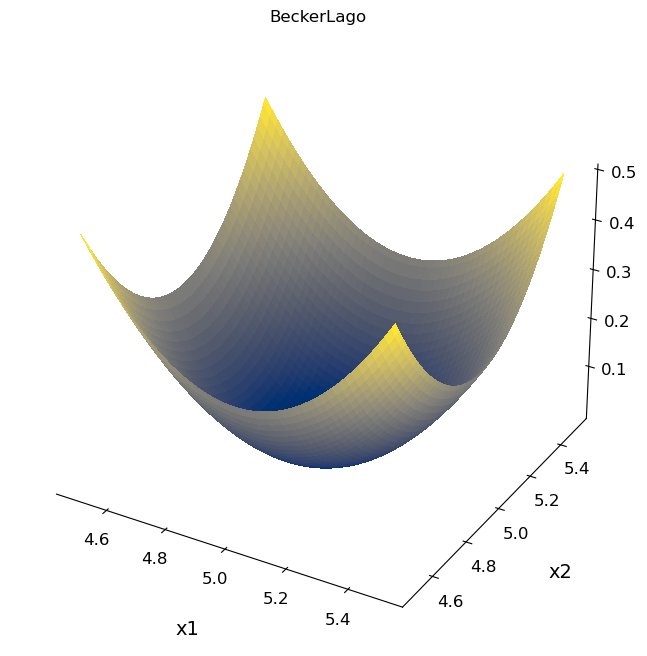

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# source contains problems as numpy array - really a dictionary
# params of bcp dictionary
# yopt - optimal value
# xopt - optimal solution
# xlb - lower bound
# xub - upper bound
# n - dimensionality
# func - function to be evaluated - exists as string version of argument where x[:,0] is first variable and x[:,1] is second variable

# names = list(bcp.keys())
# for i in names:
for i in ['BeckerLago']:
    # n defines dimensionality - ensures we are only plotting 2D problems
    if bcp[i]['n'] == 2:
        prob = bcp[i]
        xlb = prob['xlb']
        xub = prob['xub']
        # pass problem to benchmark class to enable evaluation
        prbf = benchmark(prob['func'],0)
        bounds = np.array([xlb, xub])
        x = np.linspace(bounds[0,0],bounds[1,0],100)
        y = np.linspace(bounds[0,1],bounds[1,1],100)

        X,Y = np.meshgrid(x,y)
        f = prob['func'].replace("x[:,0]", "X").replace("x[:,1]", "Y")
        Z = eval(f)

        fig = plt.figure(figsize=(8,8), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        # plt.tight_layout(rect=(4, 1, 1, 1))

        print(
            f'{i} function:\n'
            f'{prob["func"]}\n'
            f'lower bounds:\n'
            f'{xlb}\n'
            f'upper bounds:\n'
            f'{xub}\n'
            # f'number of constraints:\n'
            # f'{prob["n_con"]}'
        )

        # Plot a 3D surface
        ax.plot_surface(X, Y, Z, cmap="cividis", antialiased=False)
        ax.set_xlabel('x1',labelpad= 20, fontsize=14)
        ax.set_ylabel('x2',labelpad= 20, fontsize=14)
        ax.set_zlabel('f(x1,x2)',labelpad= 20, fontsize=14)
        ax.set_title(i)
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.zaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        plt.show()

### Identify Valid Problems

In [4]:
import numbers

def get_valid_problems(source, names):
    """ 
    Some provided solutions may be invalid. This function returns valid/invalid solutions
    """

    valid_problems = []
    invalid_problems = []
    for name in names: 
        dims = source[f'{name}']['n']
        try:
            assert len(source[f'{name}']['xub']) == dims and len(source[f'{name}']['xlb']) == dims
            assert len(source[f'{name}']['xopt']) == dims and isinstance(source[f'{name}']['yopt'], numbers.Number)
            valid_problems.append(name)
        except:
            invalid_problems.append(name)
            continue

    # print(f"There are {len(valid_problems)} valid problems and {len(invalid_problems)} invalid problems")
    
    return valid_problems, invalid_problems

names_bcp = list(bcp.keys())
names_eqc = list(eqc.keys())
bcp_valid_probs, bcp_invalid_probs = get_valid_problems(bcp, names_bcp)
eqc_valid_probs, eqc_invalid_probs = get_valid_problems(eqc, names_eqc)

all_valid_probs = bcp_valid_probs #+ eqc_valid_probs
all_valid_probs.sort()
print(f'bcp valid problems: {len(bcp_valid_probs)}')
print(f'{bcp_valid_probs}\n')
print(f'eqc valid problems: {len(eqc_valid_probs)}')
print(f'{eqc_valid_probs}\n')
print(f'total valid problems: {len(all_valid_probs)}')
print(all_valid_probs)

bcp valid problems: 263
['3pk', 'AluffiPentini', 'BeckerLago', 'Camel3', 'Camel6', 'DekkersAarts', 'Expo', 'GoldPrice', 'Hartman3', 'Hosaki', 'MeyerRoth', 'ModRosenbrock', 'MultiGauss', 'Neumaier2', 'Neumaier3', 'Paviani', 'PowellQ', 'PriceTransistor', 'Shekel10', 'Shekel7', 'Shekelfox10', 'Shekelfox5', 'Wood', 'aircrftb', 'arglinb', 'arglinc', 'biggs3', 'biggs5', 'biggs6', 'biggsb1', 'box3', 'bqp1var', 'brownal', 'brownbs', 'brownden', 'camel1', 'chnrosnb', 'cliff', 'concha1', 'concha10', 'concha11', 'concha12', 'concha2', 'concha3', 'concha4', 'concha5', 'concha5a', 'concha8', 'concha9', 'cube', 'denschna', 'denschnb', 'denschnc', 'denschnd', 'denschne', 'denschnf', 'dixon3dq', 'draper1', 'draperg', 'draperj', 'drapero', 'eigena', 'eigenals', 'eigenb', 'eigenbls', 'engval2', 'errinros', 'ex005', 'ex4_1_1', 'ex4_1_2', 'ex4_1_3', 'ex4_1_4', 'ex4_1_5', 'ex4_1_6', 'ex4_1_7', 'ex8_1_3', 'ex8_1_4', 'ex8_1_5', 'ex8_1_6', 'explin', 'explin2', 'expquad', 'extrosnb', 'fermat2_eps', 'fermat2_va

### Evaluate Problem Types

Here we evaluate the dimensionality and convexity of each valid problem for interpreting solver performance. Note: We are ignoring all constraints except upper and lower bounds, similar to the paper by Rios and Sahinidis.

In [3]:
dict_prob_types = {}

for name in all_valid_probs:
    source = ''
    dim = 0
    func = ''
    convexity = ''
    if name in bcp.keys():
        source = 'bcp'
        dim = bcp[name]['n']
        func = bcp[name]['func']
    elif name in eqc.keys():
        source = 'eqc'
        dim = eqc[name]['n']
        func = eqc[name]['func']

### General function definition for solving and evaluating results

In [5]:
from IPython.display import clear_output

# Import all optimizers explicitly into namespace
# exp_opt
from gradient_free_optimizers import EnsembleOptimizer
exp_opt = EnsembleOptimizer
#global_opt
from gradient_free_optimizers import RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer
global_opt = [RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer]
#local_opt
from gradient_free_optimizers import HillClimbingOptimizer,StochasticHillClimbingOptimizer,RepulsingHillClimbingOptimizer,SimulatedAnnealingOptimizer,DownhillSimplexOptimizer
local_opt = [HillClimbingOptimizer,StochasticHillClimbingOptimizer,RepulsingHillClimbingOptimizer,SimulatedAnnealingOptimizer,DownhillSimplexOptimizer]
#pop_opt
from gradient_free_optimizers import ParallelTemperingOptimizer,ParticleSwarmOptimizer,EvolutionStrategyOptimizer,SpiralOptimization
pop_opt = [ParallelTemperingOptimizer,ParticleSwarmOptimizer,EvolutionStrategyOptimizer,SpiralOptimization]
#smb_opt
from gradient_free_optimizers import ForestOptimizer,BayesianOptimizer,TreeStructuredParzenEstimators,LipschitzOptimizer,DirectAlgorithm
smb_opt = [ForestOptimizer,BayesianOptimizer,TreeStructuredParzenEstimators,LipschitzOptimizer,DirectAlgorithm]

# Find and replace function for editing function strings
def multiple_replace(_string:str, find_replace:list):
    new_string = _string
    for find,replace in find_replace:
        new_string = new_string.replace(find,replace)
    return new_string

# Create usable form of the function to pass to optimizers
def get_usable_fxn(dimension: int, fxn_form: str):
    find_rep_list = [('x[:,{}]'.format(dimension-1-i),'x["{}"]'.format(dimension-1-i)) for i in range(dimension)]
    opt_form = multiple_replace(fxn_form, find_rep_list)
    return opt_form

# Create search space
def create_search_space(dimension: int, xlb: list, xub: list, resolution: int = 100):
    search_space = {str(i):np.linspace(xlb[i],xub[i],resolution) for i in range(dimension)}
    return search_space

# Create a container for objective function - need to use eval to evaluate string version of function, but can't pass that
#directly to optimizer - there is probably a better way to do this, possibly using wrappers. Not worth time right now.
def create_parent_fxn(search_space,opt_form,_type='min'):
    search_space = search_space
    opt_form = opt_form
    def objective_fxn(search_space):
        clear_output(wait=True)
        x = search_space
        return -1*eval(opt_form)
    return objective_fxn

### Improve a given starting point
- Starting point will be randomly chosen from search space
- Going to set up separate loops for each class of optimizer. Will run these in .py files. Provide a single example here 
     - Dumb parallelization

In [ ]:
import tqdm
#import sys

fh = open('output.txt','w')

og = sys.stderr
#sys.stderr = fh

all_opt = global_opt + local_opt + pop_opt
taus = [1e-1,1e-2,1e-3,1e-6,0]
tmp_list = [f"{opt.__name__}\t" for opt in all_opt]+["f_x0"]
result_list = []
result_list += [''.join(tmp_list)]

for _prob in tqdm.tqdm(all_valid_probs):
    try:
        test_fxn = bcp[_prob]
    except:
        test_fxn = eqc[_prob]
    fxn_form = test_fxn['func']
    xlb = test_fxn['xlb']
    xub = test_fxn['xub']
    ndim = test_fxn['n']
    y_opt = test_fxn['yopt']
    x_opt = test_fxn['xopt']
    scales = [xub[i]-xlb[i] for i in range(ndim)]
    initial_guess = {str(i):np.random.normal(loc=x_opt[i],scale=scales[i]/3) for i in range(ndim)}
    x = initial_guess
    opt_form = get_usable_fxn(ndim, fxn_form)
    f_x0 = eval(opt_form)
    search_space = create_search_space(ndim, xlb, xub)
    if f_x0 > y_opt:
        _type = 'min'
    else:
        _type = 'max'
    parent_fxn = create_parent_fxn(search_space,opt_form,_type=_type)  
    medians = []
    for _opt in all_opt:
        f_solve = []
        #for i in range(10):
        opt = _opt(search_space, initialize={"warm_start":[initial_guess]})
        with open('initial_guesses','a') as tmp_f:
            print(initial_guess,file=tmp_f)
        try:
            opt.search(parent_fxn, n_iter=2500, verbosity=[False,False,False])
            f_solve.append(opt.best_score)
            f_solve.sort()
            median = np.median(f_solve)
            if _type == 'min':
                median = -1*median
            medians.append(median)
        except ValueError:
            medians.append(np.nan)
    tmp_list = [f"{_med}\t" for _med in medians]+[f"{f_x0}"]
    result_list += [''.join(tmp_list)]
with open('GivenSP_Results.txt','w') as f:
    f.write('\n'.join(result_list))

sys.stderr = og




IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
bcp['aircrftb']

{'yopt': 2.3318247793332352e-22,
 'xopt': array([-0.96547901,  0.06355298, -0.05792604,  0.06146673, -0.01086119,
        -0.05      ,  0.1       ,  0.        ]),
 'xub': array([ 1.1 ,  1.1 ,  1.1 ,  1.1 ,  1.1 , -0.05,  0.1 ,  0.  ]),
 'xlb': array([-1.1 , -1.1 , -1.1 , -1.1 , -1.1 , -0.05,  0.1 ,  0.  ]),
 'n': 8,
 'func': '(8.39*x[:,2]*x[:,3] - 0.727*x[:,1]*x[:,2] - 684.4*x[:,3]*x[:,4] + 63.5*x[:,3]*x[:,1] + 0.107*x[:,1] + 0.126*x[:,2] -9.99*x[:,4] - 3.933*x[:,0] - 45.83*x[:,6] - 7.64*x[:,7])**2 + (0.949*x[:,0]*x[:,2] + 0.173*x[:,0]*x[:,4] - 0.987*x[:,1] - 22.95*x[:,3] - 28.37*x[:,5])**2 + (-0.716*x[:,0]*x[:,1] - 1.578*x[:,0]*x[:,3] + 1.132*x[:,3]*x[:,1] +0.002*x[:,0] - 0.235*x[:,2] + 5.67*x[:,4] - 0.921*x[:,6] - 6.51*x[:,7])**2 + (x[:,1] - x[:,0]*x[:,4] - x[:,3] -0.168*x[:,5])**2 + (x[:,0]*x[:,3] - x[:,2] - 0.196*x[:,4] - 0.0071*x[:,6])**2'}

### Simple test of above functions - can easily be wrapped in loops to automate evaluation of all problem and optimizers
- This will serve as the boiler plate code that can easily be extended. 
- Only challenge will be optimizers with hyperparameters. Can start by using defaults

In [4]:
test_fxn = bcp['BeckerLago']
fxn_form = test_fxn['func']
xlb = test_fxn['xlb']
xub = test_fxn['xub']
ndim = test_fxn['n']
print(test_fxn.keys())

opt_form = get_usable_fxn(ndim, fxn_form)
search_space = create_search_space(ndim, xlb, xub, resolution=100)
fxn = create_parent_fxn(search_space,opt_form)
# Use first optimizer in list of local optimizers
opt = local_opt[0](search_space)
opt.search(fxn,n_iter=2500)


Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 4.994949494949495  
 
   Random seed: 1354434106  
 
   Evaluation time   : 0.3049914836883545 sec    [53.03 %]
   Optimization time : 0.27016258239746094 sec    [46.97 %]
   Iteration time    : 0.5751540660858154 sec    [4346.66 iter/sec]
 


In [5]:
test_fxn = bcp['BeckerLago']
fxn_form = test_fxn['func']
xlb = test_fxn['xlb']
xub = test_fxn['xub']
ndim = test_fxn['n']
print(test_fxn.keys())

opt_form = get_usable_fxn(ndim, fxn_form)
search_space = create_search_space(ndim, xlb, xub, resolution=100)
fxn = create_parent_fxn(search_space,opt_form)
# Use first optimizer in list of local optimizers
opt = smb_opt[0](search_space)
opt.search(fxn,n_iter=2500)


Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 4.994949494949495  
 
   Random seed: 1734231974  
 
   Evaluation time   : 1.815251111984253 sec    [0.24 %]
   Optimization time : 761.9933075904846 sec    [99.76 %]
   Iteration time    : 763.8085587024689 sec    [3.27 iter/sec]
 


### Becker Lago Problem
- Proof of concept code here: Not pretty or modular
- Evaluate the three criteria from the paper successfully
    - Ability to find global optimum within max(1.01*optimum, 0.01 + optimum)
    - Ability to improve a given starting point (not completely evaluated here - should be a fxn of tau)
    - Ability to improve near optimal solutions: handpicked here, will be defined as solution within 5% of global optimal for generalizability

In [ ]:
import numpy as np
from gradient_free_optimizers import RandomSearchOptimizer,HillClimbingOptimizer
from sympy.parsing.sympy_parser import parse_expr
from IPython.display import clear_output
fs = [RandomSearchOptimizer,HillClimbingOptimizer]
# example 2 dim problem to validate optimizer
test_fxn = bcp['BeckerLago']
fxn_form = test_fxn['func'].replace("x[:,0]", "X").replace("x[:,1]", "Y")
xlb = test_fxn['xlb']
xub = test_fxn['xub']

x = np.linspace(xlb[0],xub[0],100)
y = np.linspace(xlb[1],xub[1],100)

# Search space must be passed as a dictionary
search_space = {'X':x, 'Y':y}
optimum = {}

def parent_fxn(search_space):
    clear_output(wait=True)
    X, Y = search_space['X'], search_space['Y']
    # Note, the optimizers maximize the "objective" function, so we need to negate the function to find a minimum
    return -1*eval(fxn_form)
for f in fs:
    optimum[f.__name__] = []
    for i in range(10):
        opt = f(search_space) # initialize optimizer
        opt.search(parent_fxn, n_iter=2500) # run optimizer
        #opt.search_data.to_csv('./{}.txt'.format(f.__name__), sep='\t', index=False)
        optimum[f.__name__].append(-1*opt.best_score)

opts = ['Solver\tBest_Optimum\tAverage_Optimum\tSuccess']
for i in optimum.keys():
    optimum[i].sort()
    medians = (np.median(optimum[i]))
    offset = abs(np.array(optimum[i]) - test_fxn['yopt'])
    tmp = min(offset)
    tmp_opt = optimum[i][offset.tolist().index(tmp)]
    success = abs(test_fxn['yopt']) <= max(abs(1.01*tmp_opt),abs(tmp_opt)+0.01)
    opts += ['{}\t{}\t{}\t{}'.format(i,tmp_opt,medians,success)]
with open('BeckerLago.txt', 'w') as f:
    print('\n'.join(opts),file=f)

### Evaluate convergence from a specified starting point

In [ ]:
# pass initial guess as a dictionary to warm start optimizer
initial_guess = {'X':5.5, 'Y':5.5}
initialize={"warm_start":[initial_guess]}

optimum = {}
for f in fs:
    opt = f(search_space) # initialize optimizer
    opt.search(parent_fxn, n_iter=2500) # run optimizer
    #opt.search_data.to_csv('./{}.txt'.format(f.__name__), sep='\t', index=False)
    optimum[f.__name__] = -1*opt.best_score

opts = ['Solver\tOptimum']
for i in optimum.keys():
    tmp_opt = optimum[i]
    opts += ['{}\t{}'.format(i,tmp_opt)]
with open('BeckerLagoStartingPoint.txt', 'w') as f:
    print('\n'.join(opts),file=f)

In [ ]:
# pass initial guess as a dictionary to warm start optimizer
initial_guess = {'X':5.05, 'Y':5.05}
initialize={"warm_start":[initial_guess]}

optimum = {}
for f in fs:
    opt = f(search_space) # initialize optimizer
    opt.search(parent_fxn, n_iter=2500) # run optimizer
    #opt.search_data.to_csv('./{}.txt'.format(f.__name__), sep='\t', index=False)
    optimum[f.__name__] = -1*opt.best_score

opts = ['Solver\tOptimum']
for i in optimum.keys():
    tmp_opt = optimum[i]
    opts += ['{}\t{}'.format(i,tmp_opt)]
with open('BeckerLagoNearOptimal.txt', 'w') as f:
    print('\n'.join(opts),file=f)

In [6]:
#Plot final configuration with all guesses. Highlight optimal guess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np

### Make neat gif graphic

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import  os

#catch and ignore warnings
import warnings
warnings.filterwarnings("ignore")

def generate_plots():
    images = []
    optimal_i = 0
    data = np.genfromtxt('HillClimbingOptimizer.txt', delimiter='\t', skip_header=1)
    for i in range(1, 2501):
        x = data[:i,1]
        y = data[:i,2]
        z = data[:i,0]
        optimal_x = x[np.argmax(z)]
        optimal_y = y[np.argmax(z)]
        fig, ax = plt.subplots()
        ax.plot(x, y, 'o')
        ax.plot([optimal_x], [optimal_y], 'ro')
        ax.set_title(f"Plot {i}: Optimal ({optimal_x:.3f}, {optimal_y:.3f})")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_xlim([4.5, 5.5])
        ax.set_ylim([4.5, 5.5])
        plt.savefig(f"./figures/plot_{i}.png")
        plt.close()
        if i % 100 == 0:
            print(f"Generated {i} plots")
        if i == optimal_i + 10:
            optimal_i = i
            images.append(imageio.imread(f"./figures/plot_{i}.png"))
    imageio.mimsave("HillClimbing.gif", images, fps=10)
    # delete all the images
    for i in range(1, 2501):
        os.remove(f"./figures/plot_{i}.png")

generate_plots()

### Generate final plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import  os

#catch and ignore warnings
import warnings
warnings.filterwarnings("ignore")

def generate_final_plots(opt: list):
    for i in opt:
        data = np.genfromtxt(f'{i}.txt', delimiter='\t', skip_header=1)
        x = data[:,1]
        y = data[:,2]
        z = data[:,0]
        optimal_x = x[np.argmax(z)]
        optimal_y = y[np.argmax(z)]
        fig, ax = plt.subplots()
        ax.plot(x, y, 'o')
        ax.plot([optimal_x], [optimal_y], 'ro')
        ax.set_title(f"Plot {i}: Optimal ({optimal_x:.3f}, {optimal_y:.3f})")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_xlim([4.5, 5.5])
        ax.set_ylim([4.5, 5.5])
        plt.savefig(f"./figures/{i}_Final.png")
    plt.close()

generate_final_plots(['HillClimbingOptimizer','RandomSearchOptimizer'])

### Look at higher dimensional problem - 30 dimensions.

In [ ]:
# Higher dimensional problems
names = list(bcp.keys())
for i in names:
    # n defines dimensionality - ensures we are only plotting 2D problems
    if bcp[i]['n'] > 2:
        print(i,'\t',bcp[i]['n'])

In [ ]:
test_fxn = bcp['3pk']
fxn_form = test_fxn['func']
xlb = test_fxn['xlb']
xub = test_fxn['xub']
print(test_fxn)
print(fxn_form)
print(xlb)
print(xub)

In [ ]:
# systematically setup search space as dictionary - this is basically dictionary comprehension
#creates a dictionary with keys i and values np.linspace(xlb[i],xub[i],100) for i in range(30)
search_space = {str(i):np.linspace(xlb[i],xub[i],100) for i in range(30)}

In [ ]:
from gradient_free_optimizers import RandomSearchOptimizer
from IPython.display import clear_output

# create looped funtion to do replacement in string version of functions
def multiple_replace(_string:str, find_replace:list):
    new_string = _string
    for find,replace in find_replace:
        new_string = new_string.replace(find,replace)
    return new_string

# Create find and replace pairs as tuples using list comprehension - do in reverse order to avoid replacing only part of a number
find_rep_list = [('x[:,{}]'.format(29-i),'x["{}"]'.format(29-i)) for i in range(30)]
opt_form = multiple_replace(fxn_form, find_rep_list)

# Create a container for objective function - need to use eval to evaluate string version of function, but can't pass that
#directly to optimizer
def parent_fxn(search_space):
    #clear_output(wait=True)
    x = search_space
    return -1*eval(opt_form)

initial_guess = {str(i):90 for i in range(30)}
#opt = RandomSearchOptimizer(search_space) # initialize optimizer
opt = HillClimbingOptimizer(search_space, epsilon=0.1,initialize={"warm_start":[initial_guess]})
opt.search(parent_fxn, n_iter=100)
#opt.search(parent_fxn, n_iter=1000000) # run optimizer

In [ ]:
from gradient_free_optimizers import DirectAlgorithm

opt = DirectAlgorithm(search_space)
opt.search(parent_fxn, n_iter=10000)

In [ ]:
from gradient_free_optimizers import RandomRestartHillClimbingOptimizer

opt = RandomRestartHillClimbingOptimizer(search_space, n_iter_restart=200)
opt.search(parent_fxn, n_iter=1000)

In [ ]:
test_fxn = bcp['arglinb']
fxn_form = test_fxn['func']
xlb = test_fxn['xlb']
xub = test_fxn['xub']
print(test_fxn)
print(fxn_form)
print(xlb)
print(xub)

search_space = {str(i):np.linspace(xlb[i],xub[i],100) for i in range(10)}

In [ ]:
find_rep_list = [('x[:,{}]'.format(9-i),'x["{}"]'.format(9-i)) for i in range(10)]
opt_form = multiple_replace(fxn_form, find_rep_list)

# Create a container for objective function - need to use eval to evaluate string version of function, but can't pass that
#directly to optimizer
def parent_fxn(search_space):
    clear_output(wait=True)
    x = search_space
    return -1*eval(opt_form)

opt = RandomSearchOptimizer(search_space) # initialize optimizer
opt.search(parent_fxn, n_iter=100000) # run optimizer

In [ ]:
from gradient_free_optimizers import DirectAlgorithm

opt = DirectAlgorithm(search_space)
opt.search(parent_fxn, n_iter=10000)

### Analyze Results


In [7]:
global_results, local_results, pop_results = np.genfromtxt('GivenSP_global_opt_Results.txt', delimiter='\t')\
    ,np.genfromtxt('GivenSP_local_opt_Results.txt', delimiter='\t')\
    ,np.genfromtxt('GivenSP_pop_opt_Results.txt', delimiter='\t')

In [8]:
opt = [bcp[i]['yopt'] for i in all_valid_probs]

In [9]:
def get_results_tau(taus,f_x0,f_l, results, optimizers):
    comp = (f_x0 - results)/(f_x0 - f_l)
    solver_results = {optimizers[i].__name__:[] for i in range(len(optimizers))}
    for tau in taus:
        test = comp >= (1-tau)
        frac_comp = np.sum(test, axis=0)/test.shape[0]
        for i in range(len(optimizers)):
            solver_results[optimizers[i].__name__] += [frac_comp[i]]
    return solver_results

In [10]:
taus = [1e-1,1e-2,1e-4,1e-6,0.0]
f_x0 = global_results[1:,-1].reshape(-1,1)
f_l = np.array(opt).reshape(-1,1)
results = global_results[1:,:-1]
global_return_results = get_results_tau(taus,f_x0,f_l, results, global_opt)
f_x0 = local_results[1:,-1].reshape(-1,1)
local_return_results = get_results_tau(taus,f_x0,f_l, local_results[1:,:-1], local_opt)
f_x0 = pop_results[1:,-1].reshape(-1,1)
pop_return_results = get_results_tau(taus,f_x0,f_l, pop_results[1:,:-1], pop_opt)


/tmp/ipykernel_40340/1934646033.py:11: MatplotlibDeprecationWarning: Passing the loc parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  legendfig.legend(ax[i].get_legend_handles_labels()[0], ax[i].get_legend_handles_labels()[1],'center')


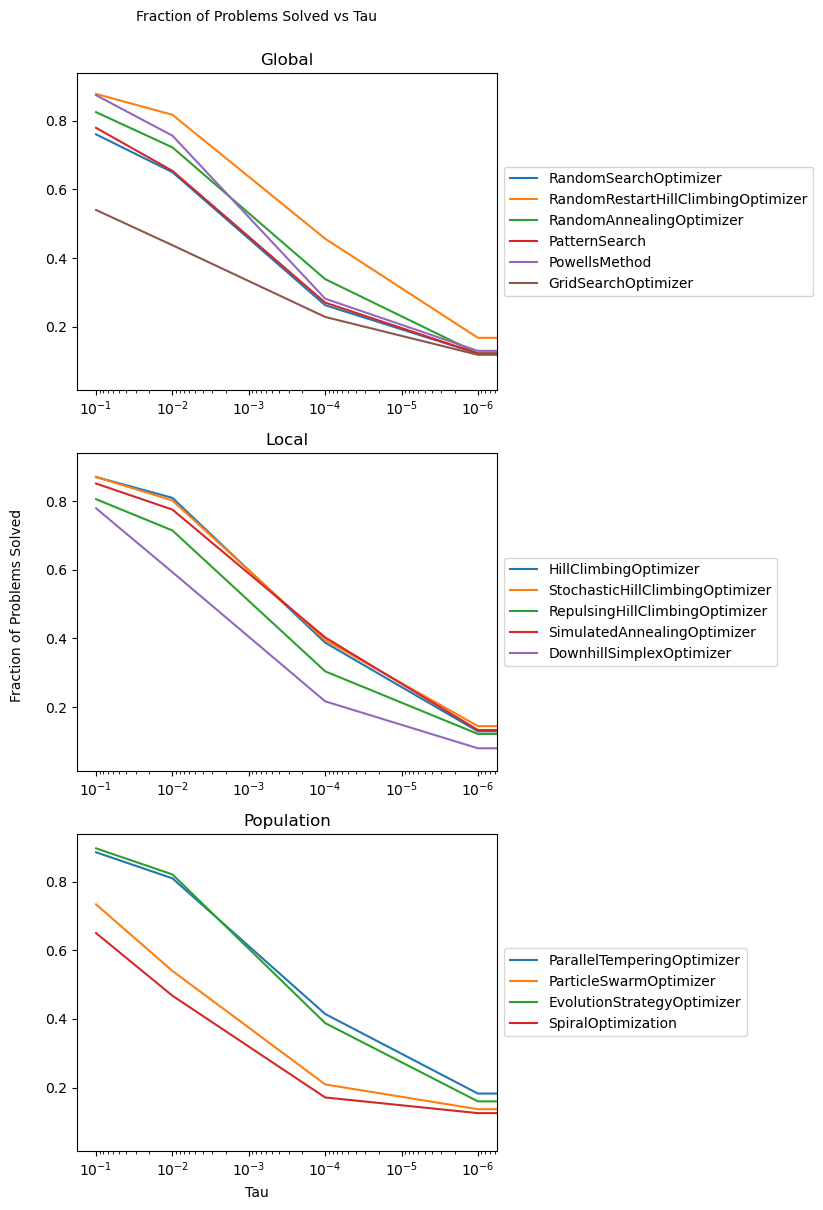

<Figure size 300x700 with 0 Axes>

<Figure size 300x700 with 0 Axes>

<Figure size 300x700 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1,figsize=(6,14), sharey=True)
final_results = [global_return_results,local_return_results,pop_return_results]
optimizers = [global_opt,local_opt,pop_opt]
titles = ['Global','Local','Population']
for i in range(3):
    current_dict = final_results[i]
    for k in range(len(current_dict.keys())):
        ax[i].semilogx(taus,current_dict[optimizers[i][k].__name__],label=optimizers[i][k].__name__)
    legendfig = plt.figure(figsize=(3,7))
    legendfig.legend(ax[i].get_legend_handles_labels()[0], ax[i].get_legend_handles_labels()[1],'center')
    legendfig.savefig('legend_{}.png'.format(i))
    ax[i].set_title(titles[i])
    ax[i].invert_xaxis()
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.text(0.5, 0.08, 'Tau', ha='center', va='center')
fig.text(0.1, 0.5, 'Fraction of Problems Solved', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.92, 'Fraction of Problems Solved vs Tau', ha='center', va='center')
plt.tight_layout()
fig.subplots_adjust(left=0.2)
fig.savefig('tau_results.png')

In [19]:
import pandas as pd
pop_table = pd.DataFrame(pop_return_results)
pop_table.style

,ParallelTemperingOptimizer,ParticleSwarmOptimizer,EvolutionStrategyOptimizer,SpiralOptimization
0,0.885932,0.733840,0.897338,0.650190
1,0.809886,0.539924,0.821293,0.467681
2,0.414449,0.209125,0.387833,0.171103
3,0.182510,0.136882,0.159696,0.125475
4,0.102662,0.087452,0.098859,0.083650


In [20]:
local_table = pd.DataFrame(local_return_results)
local_table.style

,HillClimbingOptimizer,StochasticHillClimbingOptimizer,RepulsingHillClimbingOptimizer,SimulatedAnnealingOptimizer,DownhillSimplexOptimizer
0,0.870722,0.870722,0.806084,0.851711,0.779468
1,0.809886,0.802281,0.714829,0.775665,0.593156
2,0.387833,0.395437,0.304183,0.403042,0.216730
3,0.129278,0.144487,0.121673,0.133080,0.079848
4,0.068441,0.072243,0.064639,0.076046,0.057034


In [21]:
global_table = pd.DataFrame(global_return_results)
global_table.style

,RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer
0,0.760456,0.878327,0.825095,0.779468,0.874525,0.539924
1,0.650190,0.817490,0.722433,0.653992,0.756654,0.437262
2,0.262357,0.456274,0.338403,0.269962,0.281369,0.228137
3,0.121673,0.167300,0.121673,0.121673,0.129278,0.117871
4,0.076046,0.095057,0.076046,0.076046,0.083650,0.083650


In [38]:
import imgkit

def display_dataframe_with_sci_index(df):
    sci_index = df.index.map('{:.0e}'.format)
    formatted_df = df.copy()
    formatted_df.index = sci_index
    return formatted_df

def save_table_as_png(table, name):
    new_table = display_dataframe_with_sci_index(table)
    styled_df = new_table.style.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu")
    # Convert the styled DataFrame to HTML
    html = styled_df.render()
    # Save the HTML as a PNG image
    imgkit.from_string(html, name)

global_table.set_index(pd.Index(taus),inplace=True)
save_table_as_png(global_table,'global_table.png')
local_table.set_index(pd.Index(taus),inplace=True)
save_table_as_png(local_table,'local_table.png')
pop_table.set_index(pd.Index(taus),inplace=True)
save_table_as_png(pop_table,'pop_table.png')


/tmp/ipykernel_40340/2683631950.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = styled_df.render()


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


/tmp/ipykernel_40340/2683631950.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = styled_df.render()


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


/tmp/ipykernel_40340/2683631950.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = styled_df.render()


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
